In [1]:
import sys,os,time

import tables as tb
import yaml
import numpy as np
import matplotlib.pyplot as plt
import tjmonopix.tjmonopix
import tjmonopix.scans.th_scan as th_scan
import tjmonopix.scans.source_scan as source_scan

#### how to power
# PWELL/PSUB 0V/200uA, HV0V/100uA 
# PWELL/PSUB -6V/200uA --> MIO3 6V, GAPC 5V --> run this cell
# HV 1.8V/100uA --> PWELL/PSUB 0V/200uA --> HV 20V

DUtoe=33.
chip=tjmonopix.tjmonopix.TJMonoPix(
    conf="/home/user/workspace/tjmonopix/tjmonopix_30/tjmonopix/tjmonopix_mio3.yaml",
    no_power_reset=True)
chip.init("EN_HV")

2019-11-25 20:30:58,698 [INFO ] (MainThread) GPAC: skipping power reset
2019-11-25 20:31:00,116 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 8
2019-11-25 20:31:00,195 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2019-11-25 20:31:00,286 [INFO ] (MainThread) ibias = 45
2019-11-25 20:31:00,287 [INFO ] (MainThread) ibias = 503.125nA
2019-11-25 20:31:00,565 [INFO ] (MainThread) {'VPC [V]': 1.3002327889999996, 'VDDA_DAC [mA]': 2.0039990762671183, 'VDDP [V]': 1.7782266489468406, 'VDDP OC': False, 'VDDA [mA]': 27.550888239108147, 'VDDD [V]': 1.8014440960000002, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5009997250796382, 'VPCSWSF [V]': 0.5005069754368446, 'VDDP [mA]': 77.77742784697587, 'BiasSF [V]': 1.0745223724473683, 'VDDD OC': False, 'VPC [mA]': -0.12050046881117717, 'VPCSWSF [mA]': -0.041206141950520636, 'VDDA [V]': 1.7855088356713427, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7977220453172207, 'BiasSF [mA]': 0.10088749999999999}


In [7]:
# reset configuration
chip.default_conf()
chip.reset_ibias()

2019-11-25 12:13:18,927 [INFO ] (MainThread) ibias = 45
2019-11-25 12:13:18,929 [INFO ] (MainThread) ibias = 503.125nA


In [2]:
####### CONFIGURE THE FRONT END ######
# INPUT baseline
chip.reset_ibias()
chip.set_vreset_dacunits(35,1) #1V
# OUTPUT BASELINE
chip.set_icasn_dacunits(0,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias
chip.set_vcasn_dac_dacunits(40)
# INOUT RESET rate
chip.set_ireset_dacunits(2,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01
# OUTPUT RESET rate
chip.set_ithr_dacunits(10,1)  #680pA
# BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
chip.set_idb_dacunits(40,1)  #500nA
# DC current of Amp, OUTPUT RISE TIME
chip.set_ibias_dacunits(20,1) #500nA
chip.write_conf()

2019-11-25 20:31:09,107 [INFO ] (MainThread) vreset = 1.05106299213V
2019-11-25 20:31:09,109 [INFO ] (MainThread) icasn = 0
2019-11-25 20:31:09,110 [INFO ] (MainThread) icasn = 4.375nA
2019-11-25 20:31:09,112 [INFO ] (MainThread) ireset = 2 high leakage mode
2019-11-25 20:31:09,114 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2019-11-25 20:31:09,115 [INFO ] (MainThread) ithr = 10
2019-11-25 20:31:09,117 [INFO ] (MainThread) ithr = 1.50390625nA
2019-11-25 20:31:09,118 [INFO ] (MainThread) idb = 40
2019-11-25 20:31:09,120 [INFO ] (MainThread) idb = 717.5nA
2019-11-25 20:31:09,121 [INFO ] (MainThread) ibias = 20
2019-11-25 20:31:09,123 [INFO ] (MainThread) ibias = 229.6875nA


In [9]:
#### (optional) check analog output
chip.enable_analog(col="all")
chip.set_inj_all(inj_n=0)  ## run this cell with inj_n=1 to stop injection
chip.inject()

2019-11-25 12:13:27,796 [INFO ] (MainThread) vl = 1.00862204724V
2019-11-25 12:13:27,798 [INFO ] (MainThread) vh = 1.50468503937V


2019-11-25 20:31:13,323 [INFO ] (MainThread) auto_mask th=2 step=10 exp=0.200000 fl=EN_HV
2019-11-25 20:31:14,659 [INFO ] (MainThread) Enable MASKH 10 Noise data 974
2019-11-25 20:31:14,660 [ERROR] (MainThread) Too many noisy pixels, try smaller step.


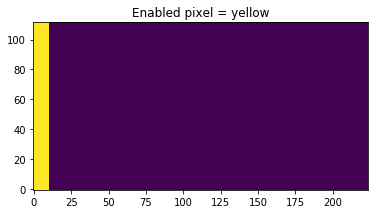

In [3]:
#### enable pixels and mask noisy pixels
chip.set_monoread()
noisy=chip.auto_mask()

mask=chip.get_pixel_status(mask=None,mode="all")
plt.imshow(chip.get_pixel_status(mask=mask,mode="preamp")[3,:,:],
           interpolation="none",origin="bottomleft")
plt.title("Enabled pixel = yellow");

In [8]:
### select one pixel
col=15
row=15
chip.enable_injection(chip.fl_n, col, row)
#chip.enable_pixel(chip.fl_n,col,row) 
#chip.enable_hitor(chip.fl_n,col,row)
mask=chip.get_pixel_status(mask=None,mode="all")
print "preamp of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="preamp")[chip.fl_n, col, row]
print "inj of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="inj")[chip.fl_n, col, row]
print "hitor of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="mon")[chip.fl_n, col, row]

preamp of [15,15]: True
inj of [15,15]: True
hitor of [15,15]: False


In [9]:
### (optional) inject 1 pixel. it is good idea to run this once/twice.
chip.set_inj_all(inj_n=1000,inj_phase=0)
#chip.reset_ibias()
chip.set_monoread()
chip.inject()
time.sleep(1)
dat=chip.interpret_data(chip['fifo'].get_data())
print "n of data", len(dat)
if len(dat)!=0:
    uni,cnt=np.unique(dat[["col",'row']], return_counts=True)
    arg=np.argsort(cnt)
    for a in arg[::-1]:
        print uni[a],cnt[a]

2019-11-25 12:19:30,216 [INFO ] (MainThread) vl = 1.00862204724V
2019-11-25 12:19:30,217 [INFO ] (MainThread) vh = 1.50468503937V


n of data 1018
(15, 15) 1000
(66, 73) 2
(61, 150) 2
(47, 76) 2
(42, 37) 2
(110, 187) 1
(96, 20) 1
(80, 167) 1
(63, 179) 1
(60, 190) 1
(56, 157) 1
(45, 109) 1
(20, 168) 1
(17, 100) 1
(4, 185) 1


2019-11-22 13:35:23,990 [INFO ] (MainThread) vl = 1.00862204724V
2019-11-22 13:35:23,991 [INFO ] (MainThread) vh = 1.50468503937V
2019-11-22 13:35:23,995 [INFO ] (MainThread) Initializing ThScan
2019-11-22 13:35:24,262 [INFO ] (MainThread) Power status: {'VPC [V]': 1.3002327889999996, 'VDDA_DAC [mA]': 2.0039990762671183, 'VDDP [V]': 1.7772265476429288, 'VDDP OC': False, 'VDDA [mA]': 13.265242527115744, 'VDDD [V]': 1.800444155, 'VDDA_DAC OC': False, 'VDDD [mA]': 7.585704998729309e-08, 'VPCSWSF [V]': 0.5000079, 'VDDP [mA]': 87.3733442595446, 'BiasSF [V]': 1.0730224200526315, 'VDDD OC': False, 'VPC [mA]': 0.07150029692889069, 'VPCSWSF [mA]': -0.09899525938503313, 'VDDA [V]': 1.7945024418837676, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7977220453172207, 'BiasSF [mA]': 0.10088749999999999}
2019-11-22 13:35:29,657 [INFO ] (MainThread) Temperature: 31.3 C
2019-11-22 13:35:29,686 [INFO ] (MainThread) Creating ZMQ context
2019-11-22 13:35:29,688 [INFO ] (MainThread) Creating socket connection to ser

0 168767 100.000% 2.203s 56256hits 0errs
data (inj_n 1000,inj_loop 35): INJ=35000 MONO=21256 MON=0


/home/user/anaconda/envs/ngap/lib/python2.7/site-packages/numba/dataflow.py:390: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)
/home/user/anaconda/envs/ngap/lib/python2.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'injlist' of function '_build_inj'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../tjmonopix/analysis/event_builder_inj.py", line 24:
@njit
def _build_inj(dat, injlist, thlist, phaselist, rowlist, inj_period, inj_n, mode, buf, scan_param_id, pre_inj, inj_id, inj_cnt):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/user/anaconda/envs/ngap/lib/python2.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encounter

0 56256 100.000% 0.840s 21254hits 0errs
delete_noninjected from 21254 to 21237 to 21237 99.920 percent
delete_cetainvalue from 21237 to 21237 100.000 percent
fit mu=4.377e+02(13.2635DU) sigma=1.760e+01(0.5332DU)


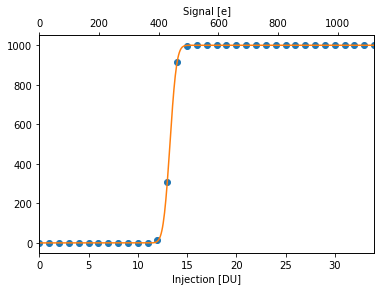

In [12]:
### S-curve
chip.set_inj_all(inj_n=1000,inj_phase=0)
reload(th_scan)
scan=th_scan.ThScan(chip)
scan.start(rowlist=np.arange(row,row+1,1), ## list of rows
           collist=np.arange(col,col+1,1), ## list of columns
           n_mask_col=1,                   ## maximum number of columns which are injected at once
           injlist=np.arange(0,35)         ## scan values of test pulse amplitude in DU
           )                               ## do not change
scan.analyze(scan.output_filename)
scan.stop()
fraw=scan.output_filename+'.h5'
fev=fraw[:-7]+'ev.h5'

with tb.open_file(fev) as f:
    cnts=f.root.Cnts[:]
    inj=f.root.ScurveFit.attrs.injlist
    fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(ncols=1,nrows=1,sharey=True)
ax=[ax]
cnts=cnts[np.bitwise_and(cnts['col']==col,cnts['row']==row)]
fit=fit[np.bitwise_and(fit['col']==col,fit['row']==row)][0]
cnt=np.zeros(len(inj))
for c in cnts:
    cnt[np.argwhere(inj==c["inj"])[0][0]]=c['cnt']
x,y=tjmonopix.analysis.utils.scurve_from_fit(th=inj,n=500,
        reverse=False,A_fit=fit["A"],mu_fit=fit["mu"],sigma_fit=fit['sigma'])
ax[0].plot(inj,cnt,"o")
ax[0].plot(x,y,"-")
ax2=ax[0].twiny()
ax[0].set_xbound(np.min(inj),np.max(inj))
ax2.set_xbound(np.min(inj)*DUtoe,np.max(inj)*DUtoe)
ax[0].set_xlabel("Injection [DU]")
ax2.set_xlabel("Signal [e]")
print "fit mu=%.3e(%.4fDU)"%(fit["mu"]*DUtoe,fit["mu"]),
print "sigma=%.3e(%.4fDU)"%(fit["sigma"]*DUtoe,fit["sigma"])

In [14]:
## Threshold scan 1col=~1.5min
chip.set_inj_all(inj_n=100,inj_phase=0)
reload(th_scan)
scan=th_scan.ThScan(chip)
scan.start(rowlist=np.arange(0,224,1), ## list of rows
           collist=np.arange(col,col+1,1), ## list of columns change here (0,112,1) for full scan
           n_mask_col=1,                   ## max number of columns to be injected
           injlist=np.arange(0,35),        ## scan values of test pulse amplitude in DU
           debug=4)                        
scan.analyze(scan.output_filename)
scan.stop()
fraw=scan.output_filename+'.h5'
fev=fraw[:-7]+'ev.h5'

2019-11-22 13:36:20,459 [INFO ] (MainThread) vl = 1.00862204724V
2019-11-22 13:36:20,461 [INFO ] (MainThread) vh = 1.50468503937V
2019-11-22 13:36:20,465 [INFO ] (MainThread) Initializing ThScan
2019-11-22 13:36:20,730 [INFO ] (MainThread) Power status: {'VPC [V]': 1.3002327889999996, 'VDDA_DAC [mA]': 2.0039990762671183, 'VDDP [V]': 1.7782266489468406, 'VDDP OC': False, 'VDDA [mA]': 13.265242527115744, 'VDDD [V]': 1.800444155, 'VDDA_DAC OC': False, 'VDDD [mA]': 7.585704998729309e-08, 'VPCSWSF [V]': 0.5000079, 'VDDP [mA]': 86.86829602730414, 'BiasSF [V]': 1.0730224200526315, 'VDDD OC': False, 'VPC [mA]': -0.055000207582143606, 'VPCSWSF [mA]': 0.10251288053878867, 'VDDA [V]': 1.7945024418837676, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7977220453172207, 'BiasSF [mA]': 0.10088749999999999}
2019-11-22 13:36:20,933 [INFO ] (MainThread) Temperature: 31.2 C
2019-11-22 13:36:20,966 [INFO ] (MainThread) Creating ZMQ context
2019-11-22 13:36:20,967 [INFO ] (MainThread) Creating socket connection to s

0 3691313 100.000% 0.049s 1230438hits 0errs
data (inj_n 100,inj_loop 7840): INJ=784000 MONO=446438 MON=0
0 1230438 100.000% 0.133s 446427hits 0errs
delete_noninjected from 446427 to 445906 to 445902 99.882 percent
delete_cetainvalue from 445902 to 445902 100.000 percent


/home/user/workspace/tjmonopix/tjmonopix_30/tjmonopix/analysis/utils.py:73: RuntimeWarning: invalid value encountered in sqrt
  err=np.sqrt(np.diag(cov))


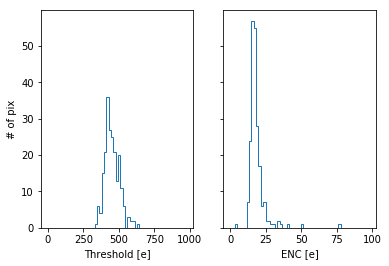

In [15]:
with tb.open_file(fev) as f:
    fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(ncols=2,nrows=1,sharey=True)
ax[0].hist(fit['mu']*DUtoe,bins=np.arange(0,30,0.5)*DUtoe,histtype="step")
ax[1].hist(fit['sigma']*DUtoe,bins=np.arange(0,3,0.05)*DUtoe,histtype="step")
ax[0].set_ylabel("# of pix")
ax[0].set_xlabel("Threshold [e]")
ax[1].set_xlabel("ENC [e]");

In [ ]:
#### plot 1pixel s-curve
with tb.open_file(fev) as f:
    cnts=f.root.Cnts[:]
    inj=f.root.ScurveFit.attrs.injlist
    fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(ncols=1,nrows=1,sharey=True)
ax=[ax]
cnts=cnts[np.bitwise_and(cnts['col']==col,cnts['row']==row)]
fit=fit[np.bitwise_and(fit['col']==col,fit['row']==row)][0]
cnt=np.zeros(len(inj))
for c in cnts:
    cnt[np.argwhere(inj==c["inj"])[0][0]]=c['cnt']
x,y=tjmonopix.analysis.utils.scurve_from_fit(th=inj,n=500,
        reverse=False,A_fit=fit['A'],mu_fit=fit['mu'],sigma_fit=fit['sigma'])
ax[0].plot(inj*DUtoe,cnt,"o")
ax[0].plot(x*DUtoe,y,"-")
ax[0].set_xlabel("Signal [e]")
print "fit mu=%.4fDU"%fit[1],"sigma=%.4fDU"%fit[2]
#print "Threshold=%.3fe"%(fit[1]*DUtoe),"ENC=%.3fe"%(fit[2]*DUtoe)

# Source scan

In [4]:
### load setting from confiuration file
with open("/home/user/workspace/tjmonopix/tjmonopix_30/tjmonopix/scans/NgapW4R2-HV.yaml") as f:
    conf=yaml.safe_load(f)
#chip=tjmonopix.tjmonopix.TJMonoPix(
#    conf=conf['dut']['file'],
#    no_power_reset=False)
#chip.init()    
    
chip.default_conf()
chip.switch_flavor(conf["dut"]['flavor'])
chip.enable_pixel(chip.fl_n,col=-1,row=-1,mask=conf['mask'])
chip.reset_ibias()

chip.set_vreset_dacunits(conf['dut']['vreset_dacunits'],1) #
chip.set_icasn_dacunits(conf['dut']['icasn_dacunits'],1) 
chip.set_ireset_dacunits(conf['dut']['ireset_dacunits']['value'],conf['dut']['ireset_dacunits']['mode'],1)
chip.set_ithr_dacunits(conf['dut']['ithr_dacunits'],1)
chip.set_idb_dacunits(conf['dut']['idb_dacunits'],1)
chip.set_ibias_dacunits(conf['dut']['ibias_dacunits'],1)
chip.reset_ibias()

2019-11-25 20:31:28,328 [INFO ] (MainThread) ibias = 45
2019-11-25 20:31:28,329 [INFO ] (MainThread) ibias = 503.125nA
2019-11-25 20:31:28,349 [INFO ] (MainThread) vreset = 1.05106299213V
2019-11-25 20:31:28,356 [INFO ] (MainThread) icasn = 0
2019-11-25 20:31:28,360 [INFO ] (MainThread) icasn = 4.375nA
2019-11-25 20:31:28,362 [INFO ] (MainThread) ireset = 2 high leakage mode
2019-11-25 20:31:28,363 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2019-11-25 20:31:28,365 [INFO ] (MainThread) ithr = 5
2019-11-25 20:31:28,366 [INFO ] (MainThread) ithr = 0.8203125nA
2019-11-25 20:31:28,368 [INFO ] (MainThread) idb = 40
2019-11-25 20:31:28,369 [INFO ] (MainThread) idb = 717.5nA
2019-11-25 20:31:28,371 [INFO ] (MainThread) ibias = 15
2019-11-25 20:31:28,372 [INFO ] (MainThread) ibias = 175.0nA


2019-11-25 18:20:31,137 [INFO ] (MainThread) Initializing SourceScan
2019-11-25 18:20:31,409 [INFO ] (MainThread) Power status: {'VPC [V]': 1.3002327889999996, 'VDDA_DAC [mA]': 2.0039990762671183, 'VDDP [V]': 1.7782266489468406, 'VDDP OC': False, 'VDDA [mA]': 16.836653955113846, 'VDDD [V]': 1.800444155, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5009997250796382, 'VPCSWSF [V]': 0.5000079, 'VDDP [mA]': 86.86829602730414, 'BiasSF [V]': 1.0745223724473683, 'VDDD OC': False, 'VPC [mA]': -0.14850058048160375, 'VPCSWSF [mA]': -0.04221117007981651, 'VDDA [V]': 1.7945024418837676, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7977220453172207, 'BiasSF [mA]': 0.10088749999999999}
2019-11-25 18:20:31,607 [INFO ] (MainThread) Temperature: 32.3 C
2019-11-25 18:20:31,635 [INFO ] (MainThread) Creating ZMQ context
2019-11-25 18:20:31,637 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-11-25 18:20:31,639 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-11

/home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_182031_source_scan.h5
0 2201 100.000% 0.000s 734hits


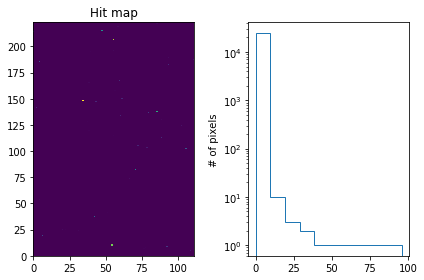

In [9]:
## noise occupancy
reload(source_scan)
scan=source_scan.SourceScan(dut=chip)
scan.start(scan_time=100,                                ## scan time in seconds
           with_mon=False,with_rx1=False,with_tlu=False) ## do not change
fhit=scan.analyze(scan.output_filename,event="none",clusterize=False)
scan.stop()

with tb.open_file(fhit) as f:
    hits=f.root.Hits[:]
fig,ax=plt.subplots(ncols=2,nrows=1)
hist=ax[0].hist2d(hits['col'],hits['row'],bins=[np.arange(0,112),np.arange(0,224)]);
ax[1].hist(np.reshape(hist[0],[-1]),histtype="step")
ax[1].set_yscale("log")
ax[0].set_title("Hit map");
ax[1].set_ylabel("# of pixels");
fig.tight_layout()

2019-11-25 20:38:30,119 [INFO ] (MainThread) Initializing SourceScan
2019-11-25 20:38:30,445 [INFO ] (MainThread) Power status: {'VPC [V]': 1.3007325834999997, 'VDDA_DAC [mA]': 2.0039990762671183, 'VDDP [V]': 1.7782266489468406, 'VDDP OC': False, 'VDDA [mA]': 13.265242527115744, 'VDDD [V]': 1.800444155, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5009997250796382, 'VPCSWSF [V]': 0.5005069754368446, 'VDDP [mA]': 86.86829602730414, 'BiasSF [V]': 1.0750223565789472, 'VDDD OC': False, 'VPC [mA]': -0.06600025145266833, 'VPCSWSF [mA]': -0.026130720011082603, 'VDDA [V]': 1.7945024418837676, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7987217764350454, 'BiasSF [mA]': 0.10139230319999999}
2019-11-25 20:38:30,643 [INFO ] (MainThread) Temperature: 32.3 C
2019-11-25 20:38:30,669 [INFO ] (MainThread) Creating ZMQ context
2019-11-25 20:38:30,671 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-11-25 20:38:30,673 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connect

2019-11-25 21:26:15,019 [INFO ] (MainThread) time=2863s dat=485493435 rate=165.385k/s temp=32.33C
2019-11-25 21:27:15,306 [INFO ] (MainThread) time=2924s dat=495695550 rate=165.260k/s temp=32.29C
2019-11-25 21:28:15,586 [INFO ] (MainThread) time=2984s dat=505950225 rate=166.107k/s temp=32.32C
2019-11-25 21:29:15,863 [INFO ] (MainThread) time=3044s dat=516148690 rate=165.230k/s temp=32.29C
2019-11-25 21:30:16,137 [INFO ] (MainThread) time=3104s dat=526362485 rate=165.477k/s temp=32.31C
2019-11-25 21:31:16,409 [INFO ] (MainThread) time=3165s dat=536590515 rate=165.754k/s temp=32.33C
2019-11-25 21:32:16,668 [INFO ] (MainThread) time=3225s dat=546812340 rate=165.628k/s temp=32.33C
2019-11-25 21:33:16,901 [INFO ] (MainThread) time=3285s dat=557020295 rate=165.504k/s temp=32.32C
2019-11-25 21:34:17,183 [INFO ] (MainThread) time=3346s dat=567220950 rate=165.257k/s temp=32.32C
2019-11-25 21:35:17,471 [INFO ] (MainThread) time=3406s dat=577476720 rate=166.139k/s temp=32.32C
2019-11-25 21:36:17,

/home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_203830_source_scan.h5
('ERROR TJMONO', 0, 0, 331372084)

('ERR TJMONO2', 1, 0, 536870979)

0 99999999 16.382% 1.023s 33333332hits
100000000 99999999 32.763% 3.642s 66666666hits
200000000 99999999 49.145% 5.098s 99999999hits
300000000 99999999 65.527% 6.636s 133333332hits
400000000 99999999 81.908% 8.220s 166666666hits
500000000 99999999 98.290% 9.804s 199999999hits
600000000 10438044 100.000% 10.679s 203479347hits
event_builder_token.build_h5() fin: /home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_203830_source_hit.h5
event_builder.build_h5() # of data:total=203479347 TLU=0 TS1=0 TS2=0 TS3=0 TJ=203478845
event_builder.build_h5() check timestamp: increase only True
event_builder.build_h5() # of event=166740066


Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "/home/user/anaconda/envs/ngap/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/user/anaconda/envs/ngap/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/user/workspace/basil/basil_30/basil/TL/SiTcp.py", line 406, in _tcp_readout
    data = bytearray(self._sock_tcp.recv(1024 * 8))
error: [Errno 104] Connection reset by peer



ImportError: No module named event_builder2

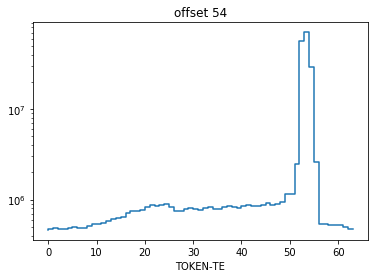

In [6]:
## Fe
reload(source_scan)
scan=source_scan.SourceScan(dut=chip)
scan.start(scan_time=3600,                                ## scan time in seconds
           with_mon=False,with_rx1=False,with_tlu=False) ## do not change
fhit=scan.analyze(scan.output_filename,event_build="token",clusterize=True)
scan.stop()

/home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_203830_source_scan.h5
('ERROR TJMONO', 0, 0, 331372084)

('ERR TJMONO2', 1, 0, 536870979)

0 99999999 16.382% 1.037s 33333332hits
100000000 99999999 32.763% 2.645s 66666666hits
200000000 99999999 49.145% 4.254s 99999999hits
300000000 99999999 65.527% 6.362s 133333332hits
400000000 99999999 81.908% 9.051s 166666666hits
500000000 99999999 98.290% 11.726s 199999999hits
600000000 10438044 100.000% 17.336s 203479347hits
event_builder_token.build_h5() fin: /home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_203830_source_hit.h5
event_builder.build_h5() # of data:total=203479347 TLU=0 TS1=0 TS2=0 TS3=0 TJ=203478845
event_builder.build_h5() check timestamp: increase only True
event_builder.build_h5() # of event=166740066


ImportError: No module named event_builder2

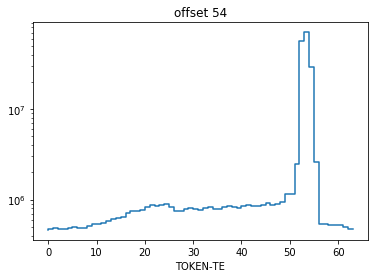

In [7]:
reload(source_scan)
fhit=scan.analyze(scan.output_filename,event_build="token",clusterize=True)

event_builder_token.build_h5() fin: /home/user/workspace/tjmonopix/tjmonopix_30/examples/output_data/20191125_182803_source_hit.h5
event_builder.build_h5() # of data:total=5736218 TLU=0 TS1=0 TS2=0 TS3=0 TJ=5736201
event_builder.build_h5() check timestamp: increase only True
event_builder.build_h5() # of event=4699519


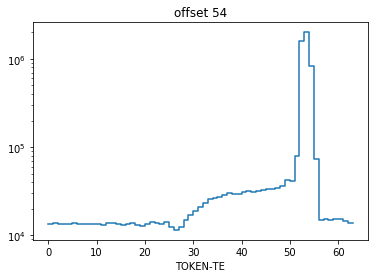

In [31]:
fraw=scan.output_filename+".h5"
fhit=fraw[:-7]+"hit.h5"
fev=fhit[:-6]+"ev.h5"
fig,ax=plt.subplots(ncols=2,nrows=2)
ax=np.reshape(ax,[-1])

with tb.open_file(fhit) as f:
    hits=f.root.Hits[:]

hist=ax[0].hist2d(hits['col'],hits['row'],bins=[np.arange(0,112),np.arange(0,224)]);
ax[1].hist(np.reshape(hist[0],[-1]),histtype="step")
ax[1].set_yscale("log")
ax[0].set_title("Hit map");
ax[1].set_ylabel("# of pixels");
fig.tight_layout()

with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
hist=ax[2].hist(hits[np.bitwise_and(hit['col']==col,hit['row']==row)]['tot']);


In [64]:
import tjmonopix.analysis.clusterizer as clusterizer
reload(clusterizer)
fcl=fhit[:-6]+"cl.h5"
clusterizer.clusterize_h5(fev,fcl)

In [62]:
import pixel_clusterizer.clusterizer as clusterizer
reload(clusterizer)
frame_cluster_distance=3
with tb.open_file(fev) as f:
        hits=f.root.Hits[:]

hits['col']=hits['col']+1
hits['row']=hits['row']+1
hits['tot']=hits['tot']+1

hit_fields={'event_number': 'event_number',  
                   'col': 'column',
                   'row': 'row',
                   'tot': 'charge',
                   'frame': 'frame'}
cl = clusterizer.HitClusterizer(hit_dtype=hits.dtype,
                                hit_fields=hit_fields,
                                column_cluster_distance=2,
                                row_cluster_distance=2,
                                frame_cluster_distance=3)
# Main functions
cluster_hits, clusters = cl.cluster_hits(hits)  # cluster hits
with tb.open_file(fcl, "w") as f:
        cluster_hits_table=f.create_table(f.root,name="Hits",description=cluster_hits.dtype, title="Hits")
        cluster_hits_table.append(cluster_hits)
        cluster_hits_table.flush()
        
        clusters_table=f.create_table(f.root,name="Clusters",description=clusters.dtype, title="Clusters")
        clusters_table.append(cluster_hits)
        clusters_table.flush()

NameError: name 'fev' is not defined